<a href="https://www.kaggle.com/methushajeyalingam/simpsons-image-processing?scriptVersionId=84345354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import keras
import tensorflow.keras

# Importing the Keras libraries and packages 
from keras.models import Sequential 

# Do Max pooling and Flattening
from keras.layers import MaxPooling2D
from keras.layers import Flatten

# To add the Fully Connected layers to the end of CNN
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization

from keras.callbacks import EarlyStopping, ModelCheckpoint

from pathlib import Path
import os

import cv2

from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from keras.optimizer_v2.adam import Adam

In [2]:
# Set a variable to hold the Path to the images directory
image_directory = Path('../input/the-simpsons-characters-dataset/simpsons_dataset')

# Create a list of all Paths within the image directory for jpg file types
filepaths = list(image_directory.glob(r'**/*.jpg'))

# Initialize labels and image lists to hold the data
labels = []
images = []

# Set the image square resize dimension to have all images the same size
image_size = 64

# A for loop to set the x and y variables for the models
for filepath in filepaths:
    # Split the path to extract the head of the path
    head = os.path.split(filepath)
    # Split the head of the previous path to extract the character name
    character = os.path.split(head[0])
    # Append the character name to the labels list
    labels.append(character[1])
    # Obtain the image data from the file path
    img = cv2.imread(str(filepath))
    # Resize the image and normalize the pixel range to be within 0 and 1
    img = cv2.resize(img, (image_size, image_size)).astype('float32') / 255.0
    # Add the image to the images list
    images.append(img)

# Convert images list to a numpy array
images = np.array(images)
# Convert the labels list to a numpy array
labels = np.array(labels)

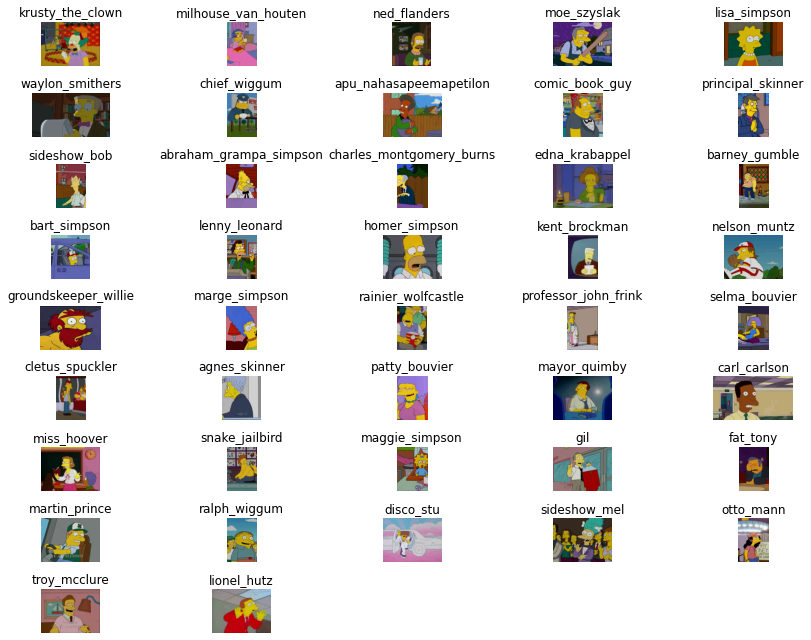

In [3]:
# Save the filepaths list as a Panda Series
pd_filepaths = pd.Series(filepaths, name='Filepath').astype(str)
# Save the labels list as a Panda Series
pd_labels = pd.Series(labels, name='Label')

# Concatenate the filepaths and labels
df = pd.concat([pd_filepaths, pd_labels], axis=1)

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop = True)

# Create a copy of the dataframe with only one image of each character
df_singles = df.copy().drop_duplicates(subset=('Label')).reset_index()

# Define the number of classes
num_classes = df_singles.shape[0]

# Set the number of rows and columns in the plot for each character to be added
ROW = 9
COLUMN = 5

# Set the dimensions of the figure of characters 
plt.figure(figsize=(12, 9)) 
# A for loop to add each character to the plot
for i in range(num_classes):
    # Set a local image variable to the i-th image in the singles dataframe
    image = df_singles.Filepath[i]
    # Set the position for the image to be plotted
    plt.subplot(ROW, COLUMN, i+1)
    # Show the image on the plot
    plt.imshow(plt.imread(image))
    # Add the label of the character that corresponds to the image
    plt.title('{}'.format(df_singles.Label[i]))
    # Turn the plot axis off
    plt.axis('off')
    # Have the padding around the images to be minimal
    plt.tight_layout()       
# Show the plot
plt.show()

In [4]:
# Set the training and testing data using the images and labels arrays
x_train, x_test, y_train, y_test = train_test_split(images,
                                           labels, test_size=0.2, random_state=44)

# Flatten the testing and training data down
x_train_flat = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2]* x_train.shape[3])
x_test_flat = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

In [5]:
# Instantiate a label encoder object to convert Strings to Numerics
label_encoder = LabelEncoder()

# Encode the String y-values to Numerical values
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Converts a class vector (integers) to a categorical class matrix.
y_train_tf = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test_tf = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [6]:
import distutils
from distutils import file_util
from distutils.file_util import copy_file

fromDirectory = '../input/the-simpsons-characters-dataset/weights.best.hdf5'
toDirectory = 'weights.best.hdf5'
copy_file(fromDirectory,toDirectory)

# Define a ModelCheckpoint object to use the best weights for this model
checkpointer = ModelCheckpoint(filepath="weights.best.hdf5", verbose=0, save_best_only=True) # save best model

# Define the input shape of the images passed through the model
input_shape = (image_size, image_size, 3)

# Define the learning rate and weight decay for the optimizer to use
learning_rate = 0.001
weight_decay = 1e-4

In [7]:
#Build network
model = Sequential()

model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape)) 
model.add(Conv2D(96, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='valid',activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.45)) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_tf.shape[1], activation='softmax'))

2022-01-03 22:32:33.466864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 22:32:33.561825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 22:32:33.562511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 22:32:33.563587: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
# Set a monitor to stop the model early when the validation loss improvement is minimal
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1, mode='auto')

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=['accuracy'])
# Save the model data to an h5 file
model.save('./simpsons.h5')
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 96)        83040     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       110720    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       1

In [9]:
# Fit the model
history = model.fit(x_train,y_train_tf, validation_split=0.2, callbacks=[monitor,checkpointer],
                    verbose=1,epochs=50, batch_size=1000, shuffle=True)      

2022-01-03 22:32:36.165260: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1316929536 exceeds 10% of free system memory.
2022-01-03 22:32:37.205524: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-03 22:32:38.945044: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 32s 744ms/step - loss: 4.5816 - accuracy: 0.1071 - val_loss: 4.5261 - val_accuracy: 0.1294
Epoch 2/50
27/27 [==============================] - 13s 484ms/step - loss: 3.5897 - accuracy: 0.2251 - val_loss: 4.2217 - val_accuracy: 0.1006
Epoch 3/50
27/27 [==============================] - 13s 484ms/step - loss: 3.1880 - accuracy: 0.3336 - val_loss: 4.1511 - val_accuracy: 0.0670
Epoch 4/50
27/27 [==============================] - 13s 483ms/step - loss: 2.8518 - accuracy: 0.4162 - val_loss: 4.1023 - val_accuracy: 0.0373
Epoch 5/50
27/27 [==============================] - 13s 484ms/step - loss: 2.5284 - accuracy: 0.4949 - val_loss: 3.9108 - val_accuracy: 0.1061
Epoch 6/50
27/27 [==============================] - 13s 484ms/step - loss: 2.2717 - accuracy: 0.5545 - val_loss: 3.8274 - val_accuracy: 0.0942
Epoch 7/50
27/27 [==============================] - 13s 486ms/step - loss: 2.0519 - accuracy: 0.6083 - val_loss: 3.8092 - val_accuracy: 0.0857
Epoch 8/50

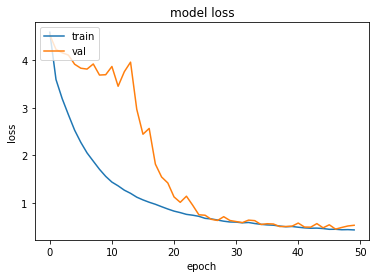

In [10]:
# Plot the summary history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

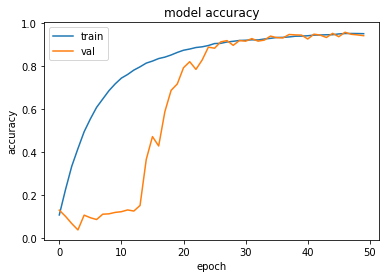

In [11]:
# Plot the summary history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
# Store the model predications of the test data to a variable
cnn_pred_simpsons = model.predict(x_test)
# Set the index of the maximum value of the prediction model to a variable
# The maximum value indicates the model prediction character the image represents
cnn_pred_simpsons = np.argmax(cnn_pred_simpsons,axis=1)
# Set a variable to hold the label representing the true character
y_true = np.argmax(y_test_tf,axis=1)

# Create an array of character names equal to the labels array
character_names = labels
# Reduce the character names to only unique dict values
character_names = list(dict.fromkeys(character_names))
# Sort the characters in alphabetical order, the which is the order the data is fed
character_names = sorted(character_names)

# Create a confusion matrix to represent the predicted vs true characters
cnn_cm_simpsons = metrics.confusion_matrix(y_true, cnn_pred_simpsons)
# Set a variable to hold the accuracy score of the model
cnn_accuracy_simpsons = metrics.accuracy_score(y_true, cnn_pred_simpsons)

# Print a classification report to contain prediction metrics for each character
print(metrics.classification_report(y_true, cnn_pred_simpsons, target_names=character_names))
# Print the accuracy score of the model
print("Accuracy score: {}".format(cnn_accuracy_simpsons))

2022-01-03 22:44:00.400095: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411598848 exceeds 10% of free system memory.
2022-01-03 22:44:00.842096: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411598848 exceeds 10% of free system memory.


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.93      0.95       341
           agnes_skinner       0.90      0.78      0.84        23
  apu_nahasapeemapetilon       0.95      0.98      0.97       253
           barney_gumble       1.00      0.72      0.84        47
            bart_simpson       0.98      0.87      0.92       548
            carl_carlson       0.98      0.91      0.94        44
charles_montgomery_burns       0.74      0.98      0.84       474
            chief_wiggum       0.95      0.98      0.96       362
         cletus_spuckler       0.91      0.59      0.71        17
          comic_book_guy       0.96      0.85      0.90       175
               disco_stu       1.00      1.00      1.00         3
          edna_krabappel       0.98      0.89      0.93       175
                fat_tony       1.00      0.67      0.80         9
                     gil       1.00      0.46      0.63        13
    groun

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


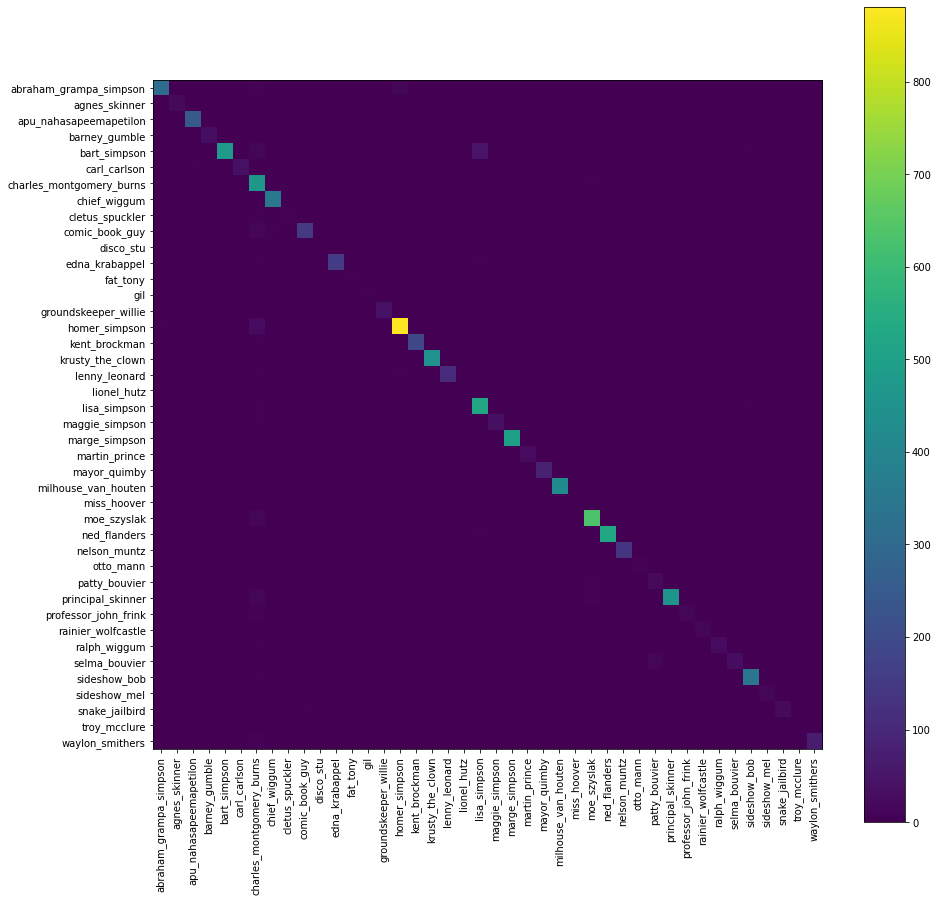

In [13]:
# Plot and save the confusion matrix
plt.figure(figsize=(15, 15))
plt.imshow(cnn_cm_simpsons, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(character_names))
plt.xticks(tick_marks, character_names, rotation=90)
plt.yticks(tick_marks, character_names)
plt.savefig('simpsons_CNN.tiff')
plt.show()

In [14]:
# Create a function to guess a character from a passed string representing the path
def guess_character(filepath):
    # Convert the file path to an image
    image = cv2.imread(filepath)
    # Resize the image and normalize the pixel range to be within 0 and 1
    img = cv2.resize(image, (image_size, image_size)).astype('float32') / 255.0
    # Expand the shape of the image array
    img = np.expand_dims(img, axis=0)
    # Use the model to predict the character representing the image
    pred = model.predict(img)
    # Set a variable to hold the index representing the character which represents the image
    classes=np.argmax(pred,axis=1)
    # Print the predicted character's name
    print(character_names[classes[0]])
    # Plot the image of the character
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Turn the plot axis off
    plt.axis('off')

bart_simpson


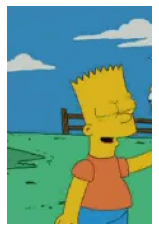

In [15]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/bart_simpson_28.jpg')

charles_montgomery_burns


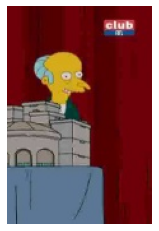

In [16]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/charles_montgomery_burns_14.jpg')

chief_wiggum


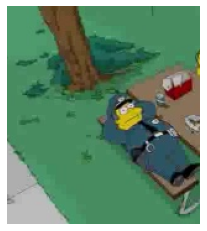

In [17]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/chief_wiggum_2.jpg')

charles_montgomery_burns


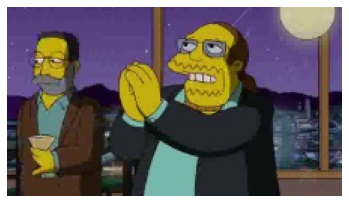

In [18]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/comic_book_guy_3.jpg')

edna_krabappel


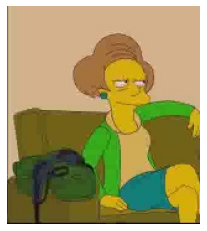

In [19]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/edna_krabappel_27.jpg')

homer_simpson


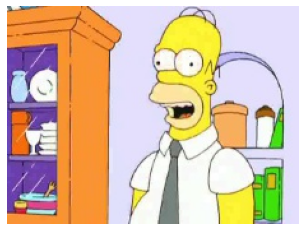

In [20]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/homer_simpson_49.jpg')

apu_nahasapeemapetilon


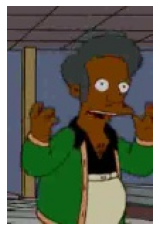

In [21]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/apu_nahasapeemapetilon_15.jpg')

waylon_smithers


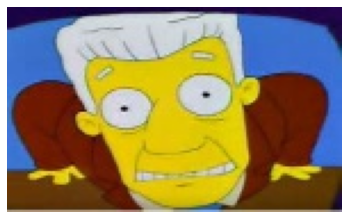

In [22]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/kent_brockman_27.jpg')

krusty_the_clown


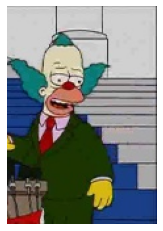

In [23]:
guess_character('../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/krusty_the_clown_12.jpg')